# Gaussian Multi-datasets

This example shows how to use `lmfit_global.py` to fit multi-dataset with gaussian function. 

This example is similar to `example_fit_multi_datasets.py` of [lmfit examples](https://lmfit.github.io/lmfit-py/examples/index.html) or [github link](https://github.com/lmfit/lmfit-py/tree/master/examples)


In [1]:
try:
    from lmfit_global import LmfitGlobal
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../lmfit_global')
    from lmfit_global import LmfitGlobal
    
import matplotlib.pyplot as plt

# Create raw data

Create five simulated Gaussian data sets

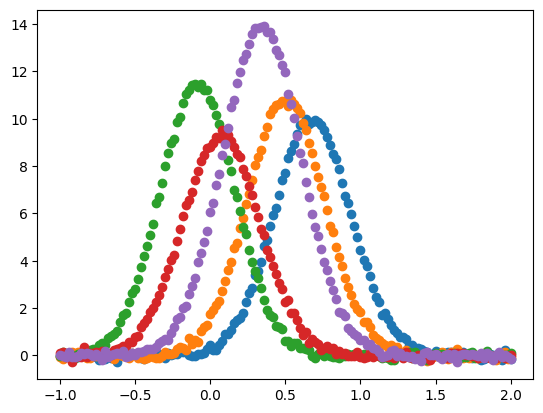

In [2]:
import os
import numpy as np
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))

def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * np.exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


# --- create raw data
# number of points per dataset
numpoints = 151
# number of datasets
ndata = 5

# xy will hold x plus ndata columns of y
xy = np.zeros((numpoints, ndata+1))

# reproducibility
np.random.seed(2021)

# x grid
x = np.linspace(-1, 2, numpoints)
xy[:, 0] = x

# plot raw data
plt.figure()
for i in range(ndata):
    amplitude = 0.60 + 9.50*np.random.rand()
    center = -0.20 + 1.20*np.random.rand()
    sigma = 0.25 + 0.03*np.random.rand()

    dat = gaussian(x, amplitude, center, sigma) \
          + np.random.normal(scale=0.1, size=x.size)

    xy[:, i+1] = dat

    plt.plot(x, dat, 'o')


<!-- # Define the model to fit the `n` multi-dataset

#### 1. Data Format
The `lmfit_global.py` `LmfitGlobal` module accepts raw input data as a NumPy array `numpy.ndarray` with shape: (nsample, ndata)

This means:
- The first column is the shared x-axis: `x`
- Each subsequent column is a separate dataset: `y_0`, `y_1`, ..., `y_n`

##### Example
```python
import numpy as np

# x values
x = np.linspace(0, 10, 100)

# multiple y datasets
y0 = np.exp(-(x - 3)**2)
y1 = np.exp(-(x - 6)**2)

# stack into shape [100, 3]
data_xy = np.column_stack([x, y0, y1])
# -- similar how we define the simulated data called `xy` above 
```

Therefore, 
- `lmfit_global.py` read the data in `dict` format
- Let define it the data block as:

```python
data_block = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }
```


#### 2. Theory: Gaussian
This model assumes each dataset follows a Gaussian profile named `gaussian` define above:

The model has three parameters: *amplitude*, *center*, and *sigma*.  
In addition, parameters `fwhm` and `height` are included as constraints to report the full width at half maximum and the maximum peak height.

$$
f(x; A, \mu, \sigma)
= \frac{A}{\sigma \sqrt{2\pi}} \exp\!\left[-\frac{(x - \mu)^2}{2\sigma^2}\right]
$$

Here, the parameter *amplitude* corresponds to $A$,  *center* corresponds to $\mu$, and   *sigma* corresponds to $\sigma$.   
The full width at half maximum (FWHM) is $\text{FWHM}= 2 \sigma \sqrt{2 \ln 2}\approx 2.3548\, \sigma .$

The model function are define as `list of dict` define below:

```python
theory_func_lst = [
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':0.5, 'vary':True, 'min':0.0, 'max':200},
            'center': {'value':0.4, 'vary':True, 'min':-2.0, 'max':2.0},
            'sigma': {'value':0.3, 'vary':True, 'min':0.01, 'max':3.0},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    {
        SAME AS ABOVE IF MULTIPLE FUNCTION/COMPONENT REQUIRE
    },
]
``` 
where,
- 'func_name': is callable function named `gaussian`
- 'init_params': is the initial parameter attributes of the function parameters named *amplitude*, *center*, and *sigma*.  
  - 'value': `float`, initial value
  - 'vary': `bool`, `True`/`False`. If True to minimize the parameter else fixed to initial value
  - 'min' & 'max': `float`, are the lower or upper bounds
- 'func_kws': keyword arguments to pass to the function (IF ANY)

NOTE: Repeat above if you are dealing with multiple function  
see example `multi_components_01.ipynb`, how to deal with this part:


Now, 
- `lmfit_global.py` read the `theory` in `dict` format define below:

```python
function_block = {
    'theory': theory_func_lst,
    'theory_connectors': [],       # see example `multi_components_01.ipynb` how to use the parameter
}
```

#### 3. Setting: *class* `LmfitGlobal`


```python
class LmfitGlobal(items, independent_vars=None, nan_policy='raise', method='leastsq', **fit_kws)
```

**Parameters**

**items** (dict): A dictionary containing the raw data and the model function

**independent_vars** (list of str, optional):
Arguments to the model function that are independent variables. Default is ['x'].

**nan_policy** ({'raise', 'propagate', 'omit'}, optional):
How to handle NaN or missing values in the data.
See Notes below.

**method** (str, optional):
Fitting method available in lmfit (default is 'leastsq')

**fit_kws** (dict, optional)
Keyword arguments to pass to the fitting/minimizer.


Notes

*nan_policy* determines what to do when a NaN or missing value is seen in the data.
It must be one of:

 - 'raise' : raise a ValueError (default)
 - 'propagate' : silently propagate NaNs
 - 'omit' : drop missing data
---


Finally, **`items`**   is define as 
```python
items = {
    'data': data_block,              # 1. data (see above)
    'functions': function_block,     # 2. thoery (see above)
}
``` -->


# Define the model to fit the `n` multi-dataset

#### 1. Data Format
The `lmfit_global.py` `LmfitGlobal` module accepts raw input data as a NumPy array `numpy.ndarray` with shape: (nsample, ndata)

This means:
- The first column is the shared x-axis: `x`
- Each subsequent column is a separate dataset: `y_0`, `y_1`, ..., `y_n`

##### Example
```python
import numpy as np

# x values
x = np.linspace(0, 10, 100)

# multiple y datasets
y0 = np.exp(-(x - 3)**2)
y1 = np.exp(-(x - 6)**2)

# stack into shape [100, 3]
data_xy = np.column_stack([x, y0, y1])
# -- similar how we define the simulated data called `xy` above 
```

Therefore, 
- `lmfit_global.py` read the data in `dict` format
- Let define it the data block as:

```python
data_block = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }
```

In [3]:
data_block = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }

#### 2. Theory: Gaussian
This model assumes each dataset follows a Gaussian profile named `gaussian` define above:

The model has three parameters: *amplitude*, *center*, and *sigma*.  

$$
f(x; A, \mu, \sigma)
= \frac{A}{\sigma \sqrt{2\pi}} \exp\!\left[-\frac{(x - \mu)^2}{2\sigma^2}\right]
$$

Here, the parameter *amplitude* corresponds to $A$,  *center* corresponds to $\mu$, and   *sigma* corresponds to $\sigma$.   
The full width at half maximum (FWHM) is $\text{FWHM}= 2 \sigma \sqrt{2 \ln 2}\approx 2.3548\, \sigma .$

The model function are define as `list of dict` define below:

```python
theory_func_lst = [
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':0.5, 'vary':True, 'min':0.0, 'max':200},
            'center': {'value':0.4, 'vary':True, 'min':-2.0, 'max':2.0},
            'sigma': {'value':0.3, 'vary':True, 'min':0.01, 'max':3.0},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    # {SAME AS ABOVE IF MULTIPLE FUNCTION/COMPONENT REQUIRE},
]
``` 
where,
- 'func_name': is callable function named `gaussian`
- 'init_params': is the initial parameter attributes of the function parameters named *amplitude*, *center*, and *sigma*.  
  - 'value': `float`, initial value
  - 'vary': `bool`, `True`/`False`. If True to minimize the parameter else fixed to initial value
  - 'min' & 'max': `float`, are the lower or upper bounds
- 'func_kws': keyword arguments to pass to the function (IF ANY)

NOTE: 
- Repeat above if you are dealing with multiple function  
- see example `multi_components_01.ipynb`, how to deal with this part:
- the `init_params` and attributes is set for all the `n` datasets


Now, 
- `lmfit_global.py` read the `theory` in `dict` format define below:

```python
function_block = {
    'theory': theory_func_lst,
    'theory_connectors': None,       # Default None, see example `multi_components_01.ipynb` how to use the parameter
}
```

In [4]:
theory_func_lst = [
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':0.5, 'vary':True, 'min':0.0, 'max':200},
            'center': {'value':0.4, 'vary':True, 'min':-2.0, 'max':2.0},
            'sigma': {'value':0.3, 'vary':True, 'min':0.01, 'max':3.0},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    # {SAME AS ABOVE IF MULTIPLE FUNCTION/COMPONENT REQUIRE },
]

function_block = {
    'theory': theory_func_lst,
    'theory_connectors': None,       # Default None, see example `multi_components_01.ipynb` how to use the parameter
}

#### 3. Setting: *class* `LmfitGlobal`


```python
class LmfitGlobal(items, independent_vars=None, nan_policy='raise', method='leastsq', **fit_kws)
```

**Parameters**

**items** (dict): A dictionary containing the raw data and the model function

**independent_vars** (list of str, optional):
Arguments to the model function that are independent variables. Default is ['x'].

**nan_policy** ({'raise', 'propagate', 'omit'}, optional):
How to handle NaN or missing values in the data.
See Notes below.

**method** (str, optional):
Fitting method available in lmfit (default is 'leastsq')

**fit_kws** (dict, optional)
Keyword arguments to pass to the fitting/minimizer.


Notes

*nan_policy* determines what to do when a NaN or missing value is seen in the data.
It must be one of:

 - 'raise' : raise a ValueError (default)
 - 'propagate' : silently propagate NaNs
 - 'omit' : drop missing data
---


Finally, **`items`**   is define as 
```python
items = {
    'data': data_block,              # 1. data (see above)
    'functions': function_block,     # 2. thoery (see above)
}
```

In [5]:
items = {
    'data': data_block,              # 1. data (see above)
    'functions': function_block,     # 2. thoery (see above)
}

### call `LmfitGlobal`

In [6]:
LFG = LmfitGlobal(items)

INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: #################################################
INFO: # y(x;) = gaussian(x, amplitude, center, sigma) #
INFO: #################################################


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0       0.5        0      200     None     True     None     None
amplitude_1       0.5        0      200     None     True     None     None
amplitude_2       0.5        0      200     None     True     None     None
amplitude_3       0.5        0      200     None     True     None     None
amplitude_4       0.5        0      200     None     True     None     None
center_0          0.4       -2        2     None     True     None     None
center_1          0.4       -2        2     None     True     None     None
center_2          0.4       -2        2     None     True     None     None
center_3          0.4       -2        2     None     True     None     None
center_4          0.4       -2        2     None     True     None     None
sigma_0           0.3     0.01        3     None     True     None     None
sigma_1           0.3     0.01        3     None     True     None     None
sigma_2   

<Axes: title={'center': 'initial fit'}, xlabel='x', ylabel='initial curve'>

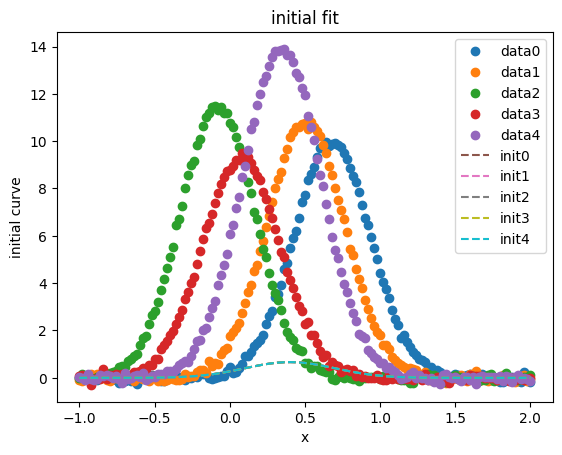

In [7]:
LFG.initial_params.pretty_print()  # pretty print initial parameters

LFG.plot_init()  # plot init parameters

# """NOTE:  Index at the end of each parameters "_0, _1, ..., _n" are index of the dataset
# """

#### Fitting....

to fit call `.fit()` function as:

`LFG.fit()`

In [8]:
LFG.fit(verbose=True)  # verbose, if True will show fit parameters

# """Note:
# - The width 'sigma_*' of the of each dataset are almost constant ~0.26
# We can set them as global/share and fit

# -  go back above and set global parameters
# """ 

INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0     6.368        0      200   0.0162     True     None     None
INFO: amplitude_1     6.987        0      200  0.01629     True     None     None
INFO: amplitude_2     7.209        0      200  0.01609     True     None     None
INFO: amplitude_3     6.028        0      200  0.01633     True     None     None
INFO: amplitude_4     9.176        0      200  0.01647     True     None     None
INFO: center_0       0.6803       -2        2 0.0007474     True     None     None
INFO: center_1       0.5045       -2        2 0.0006925     True     None     None
INFO: center_2     -0.08261       -2        2 0.0006463     True     None     None
INFO: center_3      0.07383       -2        2 0.0008092     True     None     None
INFO: center_4        0.344       -2        2 0.0005451     True     None     None
INFO: sigma_0        0.2544     0.01    

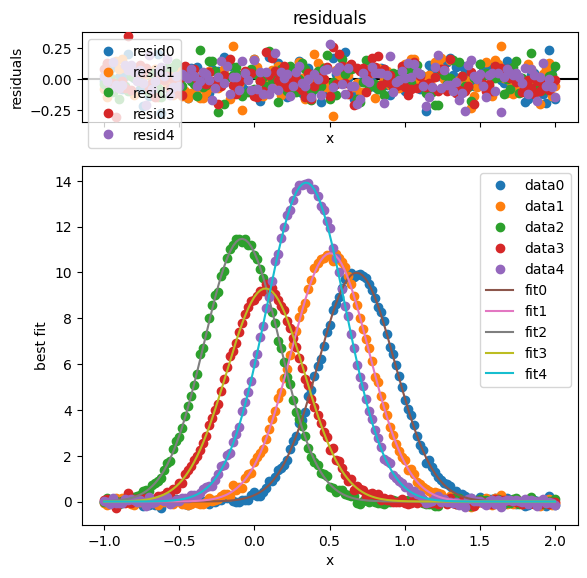

In [9]:
axes = LFG.plot(show_init=False)   # plot fit data & residuals and show initial plot (if True)

In [10]:
LFG.report()  # report fit parameters

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 162
    # data points      = 755
    # variables        = 15
    chi-square         = 7.17949050
    reduced chi-square = 0.00970201
    Akaike info crit   = -3484.89444
    Bayesian info crit = -3415.49368
    R-squared (mean)   = 0.99922614
    R-squared (weight) = 0.99928384
[[Variables]]
    amplitude_0:  6.36785257 +/- 0.01620117 (0.25%) (init = 0.5)
    center_0:     0.68031123 +/- 7.4738e-04 (0.11%) (init = 0.4)
    sigma_0:      0.25439702 +/- 7.4739e-04 (0.29%) (init = 0.3)
    amplitude_1:  6.98672430 +/- 0.01629052 (0.23%) (init = 0.5)
    center_1:     0.50446776 +/- 6.9250e-04 (0.14%) (init = 0.4)
    sigma_1:      0.25721028 +/- 6.9252e-04 (0.27%) (init = 0.3)
    amplitude_2:  7.20856121 +/- 0.01608611 (0.22%) (init = 0.5)
    center_2:    -0.08261260 +/- 6.4628e-04 (0.78%) (init = 0.4)
    sigma_2:      0.25080496 +/- 6.4625e-04 (0.26%) (init = 0.3)
    amplitude_3

In [11]:
LFG.set_global(['sigma_0'])   #set global parametes

LFG.initial_params.pretty_print()  # pretty print initial parameters

INFO: The parameter "sigma_0" is shared with ALL "sigma_*" parameters...


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0       0.5        0      200     None     True     None     None
amplitude_1       0.5        0      200     None     True     None     None
amplitude_2       0.5        0      200     None     True     None     None
amplitude_3       0.5        0      200     None     True     None     None
amplitude_4       0.5        0      200     None     True     None     None
center_0          0.4       -2        2     None     True     None     None
center_1          0.4       -2        2     None     True     None     None
center_2          0.4       -2        2     None     True     None     None
center_3          0.4       -2        2     None     True     None     None
center_4          0.4       -2        2     None     True     None     None
sigma_0           0.3     0.01        3     None     True     None     None
sigma_1           0.3     0.01        3     None    False  sigma_0     None
sigma_2   

INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0     6.406        0      200  0.01575     True     None     None
INFO: amplitude_1      6.99        0      200  0.01586     True     None     None
INFO: amplitude_2     7.302        0      200  0.01592     True     None     None
INFO: amplitude_3     6.015        0      200  0.01568     True     None     None
INFO: amplitude_4     9.077        0      200  0.01632     True     None     None
INFO: center_0       0.6803       -2        2 0.0008621     True     None     None
INFO: center_1       0.5045       -2        2  0.00079     True     None     None
INFO: center_2     -0.08261       -2        2 0.0007563     True     None     None
INFO: center_3      0.07383       -2        2 0.0009181     True     None     None
INFO: center_4        0.344       -2        2 0.0006083     True     None     None
INFO: sigma_0        0.2574     0.01     

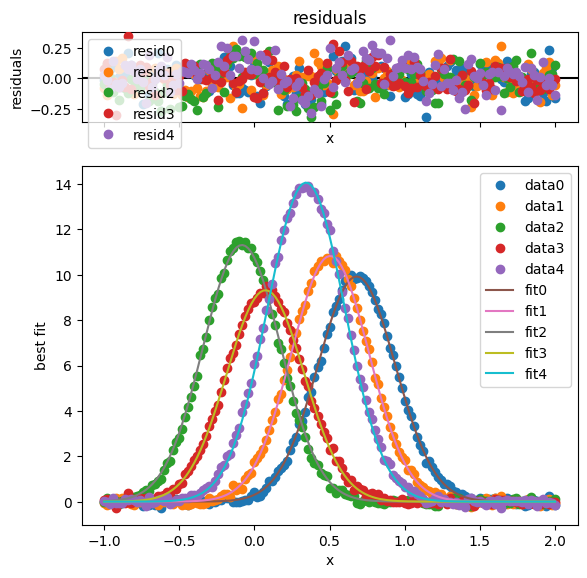

In [12]:
# repeat

LFG.fit(verbose=True)  # verbose, if True will show fit parameters

# """all sigma share same values
# """

axes = LFG.plot(show_init=False)   # plot fit data and show initial plot 

In [13]:
LFG.report()  # report fit parameters

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 755
    # variables        = 11
    chi-square         = 9.37838901
    reduced chi-square = 0.01260536
    Akaike info crit   = -3291.17386
    Bayesian info crit = -3240.27996
    R-squared (mean)   = 0.99904119
    R-squared (weight) = 0.99906449
[[Variables]]
    amplitude_0:  6.40552155 +/- 0.01575090 (0.25%) (init = 0.5)
    center_0:     0.68032886 +/- 8.6209e-04 (0.13%) (init = 0.4)
    sigma_0:      0.25743367 +/- 3.4131e-04 (0.13%) (init = 0.3)
    amplitude_1:  6.98975626 +/- 0.01585971 (0.23%) (init = 0.5)
    center_1:     0.50446887 +/- 7.9004e-04 (0.16%) (init = 0.4)
    sigma_1:      0.25743367 +/- 3.4131e-04 (0.13%) == 'sigma_0'
    amplitude_2:  7.30195609 +/- 0.01592142 (0.22%) (init = 0.5)
    center_2:    -0.08261146 +/- 7.5626e-04 (0.92%) (init = 0.4)
    sigma_2:      0.25743367 +/- 3.4131e-04 (0.13%) == 'sigma_0'
    amplitude_3: